



Estimate the binding fluxes using the methods in Hammes, G. G., Chang, Y.-C., & Oas, T. G. (2009). Conformational selection or induced fit: a flux description of reaction mechanism. Proceedings of the National Academy of Sciences of the United States of America, 106(33), 13737–13741. http://doi.org/10.1073/pnas.0907195106

In [1]:
def solve_free_protein(mdm2_tot,p53_tot,k_d_w,k_d_t,k_eq_wt,alpha=1.):
    k_d_w *= alpha
    k_d_t *= alpha
    a = 1./k_d_w+k_eq_wt/k_d_t
    b = 1.+k_eq_wt-mdm2_tot/k_d_w-k_eq_wt/k_d_t*mdm2_tot+p53_tot/k_d_w+p53_tot*k_eq_wt/k_d_t
    c = -(1.+k_eq_wt)*mdm2_tot
    #print a,b,c
    mdm2_free1 = (-b+(b*b-4.*a*c)**0.5)/(2.*a)
    mdm2_free2 = (-b-(b*b-4.*a*c)**0.5)/(2.*a)
    return max(mdm2_free1,mdm2_free2)

In [2]:
def estimate_flux(p53_tot,k_wt,k_d_w,k_d_t,k_on_t,k_on_w,k_wt_l,mdm2_free):

    p53_w_unbound = p53_tot/(1+mdm2_free/k_d_w+k_eq_wt+k_eq_wt/k_d_t*mdm2_free)
    p53_t_unbound = k_eq_wt*p53_w_unbound
    p53_w_bound = p53_w_unbound/k_d_w*mdm2_free
    #p53_t_bound = k_eq_wt*p53_w_unbound/k_d_t*mdm2_free

    flux_cs = (1/(k_wt*p53_w_unbound)+1/(k_on_t*p53_t_unbound*mdm2_free))**-1
    flux_if = (1/(k_on_w*p53_w_unbound*mdm2_free+1/k_wt_l*p53_w_bound))**-1

    return flux_cs,flux_if

In [3]:
def estimate_binding_affinity(p53_tot,k_wt,k_d_w,k_d_t,k_on_t,k_on_w,k_wt_l,mdm2_free,k_eq_wt):
    p53_w_unbound = p53_tot/(1+mdm2_free/k_d_w+k_eq_wt+k_eq_wt/k_d_t*mdm2_free)
    p53_t_unbound = k_eq_wt*p53_w_unbound
    p53_w_bound = p53_w_unbound/k_d_w*mdm2_free
    p53_t_bound = k_eq_wt*p53_w_unbound/k_d_t*mdm2_free
    
    return p53_t_bound/(p53_w_unbound+p53_t_unbound+p53_w_bound)

Rates and concentrations from the reference PNAS paper, Figure 3

In [4]:
#c_p53 = 20e-6
#k_d_w = 580./1e8
#k_d_t = 0.025/3e4
#k_eq_wt = 46./0.005

Rates and concentrations from our simulation. Rates are estimated using TPT

In [5]:
c_p53 = 7.1*10**-3 #Mol
c_mdm2 = 7.1*10**-3


#k_off_t = k_fold_bound_to_fold_unbound = 1.704e+06 (1/s)
k_off_t = 1.704e+06
#k_on_t = k_fold_unbound_to_fold_bound = 4.709e+10 1/(M*s)
k_on_t = 4.709e+10
# k_off_t/k_on_t = k_fold_bound_to_fold_unbound/k_fold_unbound_to_fold_bound
k_d_t = k_off_t/k_on_t

#k_off_w = k_unfold_bound_to_unfold_unbound = 7.120e+06
k_off_w = 7.120e+06
#k_on_w = k_unfold_unbound_to_unfold_bound = 8.980e+09 1/(M*s)
k_on_w = 8.980e+09
# k_off_w/k_on_w = k_unfold_bound_to_unfold_unbound/k_unfold_unbound_to_unfold_bound
k_d_w = k_off_w/k_on_w

#k_wt_l= k_w_to_t_bound = k_unfold_bound_to_fold_bound = 3.126e+06
k_wt_l = 3.126e+06

#k_wt = k_w_to_t_unbound = k_unfold_unbound_to_fold_unbound = 6.145e+05
k_wt = 6.145e+05
#k_tw = k_t_to_w = k_fold_unbound_to_unfold_unbound = 2.162e+06
k_tw = 2.162e+06
# k_eq_wt = k_w_to_t/k_t_to_w = k_unfold_unbound_to_fold_unbound/k_fold_unbound_to_unfold_unbound
k_eq_wt = k_wt/k_tw

In [6]:
mdm2_free = solve_free_protein(mdm2_tot=c_p53, p53_tot=c_p53,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
print mdm2_free

0.000932156612795


In [7]:
print estimate_flux(p53_tot=c_p53,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)

(425.0972637910741, 6075.920995680314)


## Fix the concentration of p53 and vary the concentration of MDM2

### p53 concentration = 7.1 mM from our simulation

In [8]:
import numpy as np

concentrations = 10**(np.arange(-7,0,0.1))

flux_ratio_vs_mdm2 = []
binding_affinity_vs_mdm2 = []

for c_mdm2 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=c_mdm2, p53_tot=7.1e-3,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=7.1e-3,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    affinity = estimate_binding_affinity(p53_tot=7.1e-3,k_wt=k_wt,
                                         k_d_w=k_d_w,k_d_t=k_d_t,
                                         k_on_t=k_on_t,k_on_w=k_on_w,
                                         k_wt_l=k_wt_l,mdm2_free=mdm2_free,
                                         k_eq_wt=k_eq_wt)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio_vs_mdm2.append(flux_cs/(flux_cs+flux_if))
    binding_affinity_vs_mdm2.append(affinity)


### p53 concentration = 7.1 uM

In [9]:
flux_ratio1_vs_mdm2 = []

for c_mdm2 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=c_mdm2, p53_tot=7.1e-6,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=7.1e-6,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio1_vs_mdm2.append(flux_cs/(flux_cs+flux_if))
    

In [10]:
%matplotlib inline

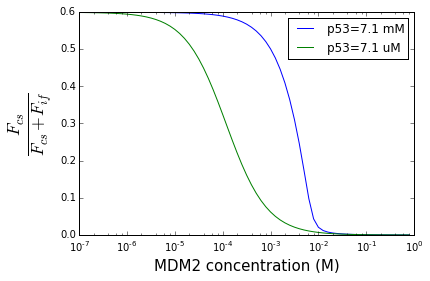

In [11]:
import matplotlib.pyplot as plt

plt.plot(concentrations,flux_ratio_vs_mdm2)
plt.plot(concentrations,flux_ratio1_vs_mdm2)
plt.ylabel(r"$\frac{F_{cs}}{F_{cs}+F_{if}}$",fontsize=25)
plt.xlabel(r"MDM2 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["p53=7.1 mM","p53=7.1 uM"],loc='best')
plt.xscale('log')


## Fixed the concentration of MDM2 and vary the concentration of p53

### mdm2 = 7.1 mM from simulation

In [12]:
import numpy as np

concentrations = 10**(np.arange(-7,0,0.1))

flux_ratio_vs_p53 = []
binding_affinity_vs_p53 = []
for c_p53 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=7.1e-3, p53_tot=c_p53,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=c_p53,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    affinity = estimate_binding_affinity(p53_tot=c_p53,k_wt=k_wt,
                                         k_d_w=k_d_w,k_d_t=k_d_t,
                                         k_on_t=k_on_t,k_on_w=k_on_w,
                                         k_wt_l=k_wt_l,mdm2_free=mdm2_free,
                                         k_eq_wt=k_eq_wt)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio_vs_p53.append(flux_cs/(flux_cs+flux_if))
    binding_affinity_vs_p53.append(affinity)

### mdm2 = 7.1 uM 

In [13]:
concentrations = 10**(np.arange(-7,0,0.1))

flux_ratio1_vs_p53 = []

for c_p53 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=7.1e-6, p53_tot=c_p53,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=c_p53,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio1_vs_p53.append(flux_cs/(flux_cs+flux_if))


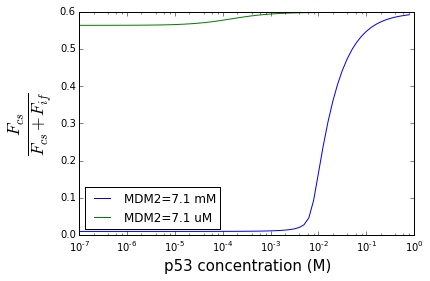

In [14]:
import matplotlib.pyplot as plt

plt.plot(concentrations,flux_ratio_vs_p53)
plt.plot(concentrations,flux_ratio1_vs_p53)
plt.ylabel(r"$\frac{F_{cs}}{F_{cs}+F_{if}}$",fontsize=25)
plt.xlabel(r"p53 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["MDM2=7.1 mM","MDM2=7.1 uM"],loc='best')
plt.xscale('log')

### Change the k_wt according to the helicity.(folded vs unfolded population change)

According to the equation: $k_{ab} = \sqrt{\frac{\pi_b}{\pi_a}}$ (Dixit. etc. JCTC,2015)

$$helicity\% = \frac{\pi_{helix}}{\pi_{helix}+\pi_{coil}} = \frac{\pi_{t}}{\pi_{t}+\pi_{w}}$$

$$k_{wt}^{'} = k_{wt}(\frac{\pi_{t}^{'}\pi_{w}}{\pi_{w}^{'}\pi_{t}})^{0.5}$$

We change the $k_{wt}$ from simulation to $k_{wt}^{'}$ according to the helicity% of p53-P27A, Borcherds, W. et al. (2014). Nature Chemical Biology, 10(12), 1000–1002.

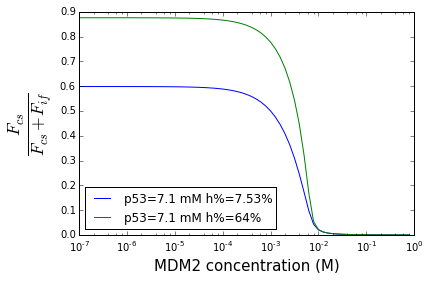

In [15]:
h = 7.35e-2 #7.35% helicity from simulation
h_new = 0.64 # 64% helicity p53-P27A from "Borcherds, W. et al. (2014). Nature Chemical Biology, 10(12), 1000–1002." 
k_wt_new = k_wt*(h_new*(1-h)/(h*(1-h_new)))**0.5
# k_eq_wt = k_w_to_t/k_t_to_w = k_unfold_unbound_to_fold_unbound/k_fold_unbound_to_unfold_unbound
#                = 6.145e+05/2.162e+06
k_eq_wt = k_wt_new/2.162e+06



concentrations = 10**(np.arange(-7,0,0.1))

flux_ratio_high_helicity_vs_mdm2 = []
binding_affinity_high_helicity_vs_mdm2 = []

#p53 = 7.1 mM from simulation
c_p53 = 7.1e-3

for c_mdm2 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=c_mdm2, p53_tot=c_p53,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=c_p53,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    affinity = estimate_binding_affinity(p53_tot=c_p53,k_wt=k_wt,
                                         k_d_w=k_d_w,k_d_t=k_d_t,
                                         k_on_t=k_on_t,k_on_w=k_on_w,
                                         k_wt_l=k_wt_l,mdm2_free=mdm2_free,
                                         k_eq_wt=k_eq_wt)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio_high_helicity_vs_mdm2.append(flux_cs/(flux_cs+flux_if))
    binding_affinity_high_helicity_vs_mdm2.append(affinity)
    
plt.plot(concentrations,flux_ratio_vs_mdm2)
plt.plot(concentrations,flux_ratio_high_helicity_vs_mdm2)
plt.ylabel(r"$\frac{F_{cs}}{F_{cs}+F_{if}}$",fontsize=25)
plt.xlabel(r"MDM2 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["p53=7.1 mM h%=7.53%","p53=7.1 mM h%=64%"],loc='best')
plt.xscale('log')

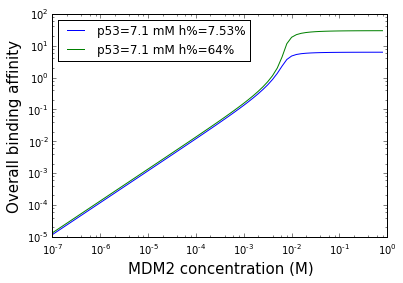

In [16]:
plt.plot(concentrations,binding_affinity_vs_mdm2)
plt.plot(concentrations,binding_affinity_high_helicity_vs_mdm2)
plt.ylabel(r"Overall binding affinity",fontsize=15)
plt.xlabel(r"MDM2 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["p53=7.1 mM h%=7.53%","p53=7.1 mM h%=64%"],loc='best')
plt.xscale('log')
plt.yscale('log')

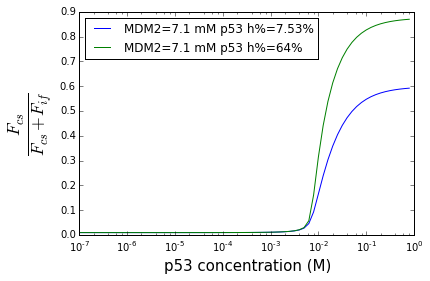

In [17]:
#mdm2 = 7.1 mM from simulation

flux_ratio_high_helicity_vs_p53 = []
binding_affinity_high_helicity_vs_p53 = []
for c_p53 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=7.1e-3, p53_tot=c_p53,
                         k_d_w=k_d_w, k_d_t=k_d_t,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=c_p53,k_wt=k_wt
                    ,k_d_w=k_d_w,k_d_t=k_d_t
                    ,k_on_t=k_on_t,k_on_w=k_on_w
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    affinity = estimate_binding_affinity(p53_tot=c_p53,k_wt=k_wt,
                                         k_d_w=k_d_w,k_d_t=k_d_t,
                                         k_on_t=k_on_t,k_on_w=k_on_w,
                                         k_wt_l=k_wt_l,mdm2_free=mdm2_free,
                                         k_eq_wt=k_eq_wt)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio_high_helicity_vs_p53.append(flux_cs/(flux_cs+flux_if))
    binding_affinity_high_helicity_vs_p53.append(affinity)
    
plt.plot(concentrations,flux_ratio_vs_p53)
plt.plot(concentrations,flux_ratio_high_helicity_vs_p53)
plt.ylabel(r"$\frac{F_{cs}}{F_{cs}+F_{if}}$",fontsize=25)
plt.xlabel(r"p53 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["MDM2=7.1 mM p53 h%=7.53%","MDM2=7.1 mM p53 h%=64%"],loc='best')
plt.xscale('log')

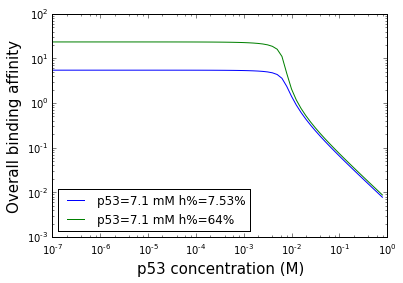

In [18]:
plt.plot(concentrations,binding_affinity_vs_p53)
plt.plot(concentrations,binding_affinity_high_helicity_vs_p53)
plt.ylabel(r"Overall binding affinity",fontsize=15)
plt.xlabel(r"p53 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["p53=7.1 mM h%=7.53%","p53=7.1 mM h%=64%"],loc='best')
plt.xscale('log')
plt.yscale('log')

### Scale k_off and k_on

Rescale k_on_t, k_off_t, k_on_w and k_off_w according to the overall k_on and k_off estimated from simulation and the experimental k_off value(2.0 1/s) k_on(9.2e+06 1/(M*s))


k_off_overall is estimated from 1000 microstate model using TPT. The source state is fold_bound and the sink state is unbound states. k_on_overall used the unbound states as the source and fold_bound as the 

In [19]:
k_off_overall = 1.321e+07 # 1/s
k_off_exp = 2.0

k_on_overall = 2.532e+09 #1/(M*s)
k_on_exp = 9.2e+06

factor_k_off =  k_off_exp/k_off_overall
factor_k_on = k_on_exp /k_on_overall

In [20]:
k_off_t_scaled = k_off_t*factor_k_off
k_on_t_scaled = k_on_t*factor_k_on
k_d_t_scaled = k_off_t_scaled/k_on_t_scaled
k_on_w_scaled = k_on_w*factor_k_on
k_off_w_scaled = k_off_w*factor_k_off
k_d_w_scaled = k_off_w_scaled/k_on_w_scaled

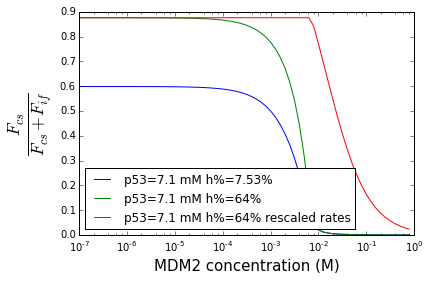

In [21]:
concentrations = 10**(np.arange(-7,0,0.1))

flux_ratio_scaled_rates_high_helicity_vs_mdm2 = []
binding_affinity_scaled_rates_high_helicity_vs_mdm2 = []

#p53 = 7.1 mM from simulation
c_p53 = 7.1e-3

for c_mdm2 in concentrations:
    mdm2_free = solve_free_protein(mdm2_tot=c_mdm2, p53_tot=c_p53,
                         k_d_w=k_d_w_scaled, k_d_t=k_d_t_scaled,
                         k_eq_wt=k_eq_wt, alpha=1)
    flux_cs,flux_if = estimate_flux(p53_tot=c_p53,k_wt=k_wt
                    ,k_d_w=k_d_w_scaled,k_d_t=k_d_t_scaled
                    ,k_on_t=k_on_t_scaled,k_on_w=k_on_w_scaled
                    ,k_wt_l=k_wt_l,mdm2_free=mdm2_free)
    affinity = estimate_binding_affinity(p53_tot=c_p53,k_wt=k_wt,
                                         k_d_w=k_d_w_scaled,k_d_t=k_d_t_scaled,
                                         k_on_t=k_on_t_scaled,k_on_w=k_on_w_scaled,
                                         k_wt_l=k_wt_l,mdm2_free=mdm2_free,
                                         k_eq_wt=k_eq_wt)
    #print "F_cs:",flux_cs,"F_if:",flux_if,"F_cs/(F_cs+F_if):",flux_cs/(flux_cs+flux_if)
    flux_ratio_scaled_rates_high_helicity_vs_mdm2.append(flux_cs/(flux_cs+flux_if))
    binding_affinity_scaled_rates_high_helicity_vs_mdm2.append(affinity)
    
plt.plot(concentrations,flux_ratio_vs_mdm2)
plt.plot(concentrations,flux_ratio_high_helicity_vs_mdm2)
plt.plot(concentrations,flux_ratio_scaled_rates_high_helicity_vs_mdm2)
plt.ylabel(r"$\frac{F_{cs}}{F_{cs}+F_{if}}$",fontsize=25)
plt.xlabel(r"MDM2 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["p53=7.1 mM h%=7.53%","p53=7.1 mM h%=64%","p53=7.1 mM h%=64% rescaled rates"],loc='best')
plt.xscale('log')

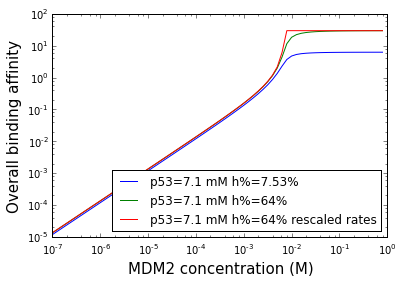

In [22]:
plt.plot(concentrations,binding_affinity_vs_mdm2)
plt.plot(concentrations,binding_affinity_high_helicity_vs_mdm2)
plt.plot(concentrations,binding_affinity_scaled_rates_high_helicity_vs_mdm2)
plt.ylabel(r"Overall binding affinity",fontsize=15)
plt.xlabel(r"MDM2 concentration (M)",fontsize=15)
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.legend(["p53=7.1 mM h%=7.53%","p53=7.1 mM h%=64%","p53=7.1 mM h%=64% rescaled rates"],loc='best')
plt.xscale('log')
plt.yscale('log')